In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns

In [49]:
data = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')
data.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [50]:
data = data[data.l2.isin(['Capital Federal']) &
            data.property_type.isin(['Departamento', 'Casa', 'PH']) &
            (data.surface_total <= 1000) & (data.surface_total>=15) & (data.price <= 4000000)
            ]
data = data[['price', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type','l3','title']]
data=data[~(data.surface_covered>data.surface_total)]


Primero vamos aplicar el filtro de las 3 sigmas para tratar a los valores atipicos, esto lo aplicaremos para todas las variables del dataset que luego utilizaremos como predictoras

In [51]:
def sigma_filter (df, column):
    valor_medio = df[column].mean()
    std = df[column].std()
    minimo = valor_medio - 3 * std
    maximo = valor_medio + 3 * std
    filters = np.logical_or (data[column] < minimo , data[column] > maximo)
    return df[~filters]


In [7]:
data_sigma = sigma_filter(data,"bedrooms")
data_sigma.shape

(145464, 19)

Vemos en el grafico de caja y bigote que tras la aplicacion de la regla de 3 sigmas, ya no se ven outliers.

In [9]:
data_sigma = sigma_filter(data,"surface_total")
data_sigma.shape

(146329, 19)

Vemos en el grafico de caja y bigote que tras la aplicacion de la regla de 3 sigmas, la reduccion de los outliers.

In [7]:
data_sigma = sigma_filter(data,"surface_covered")
data_sigma.shape

(79791, 9)

Aqui vemos lo mismo que en el grafico anterior

In [8]:
data_sigma = sigma_filter(data,"bathrooms")
data_sigma.shape

(80828, 9)

Nuevamente lo mismo, se reducen los outliers en menor proporcion que antes.

In [9]:
data_sigma = sigma_filter(data,"rooms")
data_sigma.shape

(80362, 9)

Por ultimo, aplicamos este tratamiento a nuestra ultima variable predictora "rooms".

Vemos la correlaciones entre las variables como lo hicimos en el proyecto1

El Objetivo es abordar otro tipo de analisis/problema, lo que vamos a probar es un nuevo modelo dentro de la topologia de NLP(Procesamiento de lenguaje natural), en este caso vamos abordar el problema con la libreria Topic Modelling de nltk con una tecncia de LDA, precisamente lo que vamos a buscar es crear un cluster a partir de las palabras de la columna title, poder ofrecer recomendaciones de propiedades y aprovechar esta variable.

In [2]:
import nltk
import itertools
# Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marcos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marcos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
data_nlp = data.copy()
data_nlp.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [31]:
data_nlp.drop(["price","rooms","bedrooms","bathrooms","surface_total","surface_covered","l3","property_type"],axis=1, inplace=True)

In [32]:
data_nlp.head()

,start_date,end_date,created_on,lat,lon,l1,l2,currency,title,description,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,Venta


In [33]:
index_random = np.random.randint(0,high = data_nlp.shape[0])
titular = data_nlp.iloc[index_random].title
print(index_random, titular)

46648 Duplex tipo departamento!!


Vamos a tener que convertir la columna en un string, para que podamos tokenizar

In [34]:
data_nlp['title']=data_nlp['title'].apply(str)

In [35]:
data_nlp['title'] = data_nlp['title'].fillna('').apply(str)

In [36]:
data_nlp.isna().sum()

start_date           0
end_date             0
created_on           0
lat               9925
lon               9959
l1                   0
l2                   0
currency             0
title                0
description          0
operation_type       0
dtype: int64

Para tokenizar primero es necesario entender frente a que tipo de dato estamos.

In [37]:
data_nlp.dtypes

start_date         object
end_date           object
created_on         object
lat               float64
lon               float64
l1                 object
l2                 object
currency           object
title              object
description        object
operation_type     object
dtype: object

Como el tipo de dato es un objeto, convertimos a string con pandas para poder tokenizar este dato.

In [38]:
data_nlp = str(data_nlp)
data_nlp

'        start_date    end_date  created_on        lat        lon         l1  \\\n0       2019-10-17  2019-12-23  2019-10-17 -34.605880 -58.384949  Argentina   \n1       2019-10-17  2019-11-21  2019-10-17 -34.624056 -58.412110  Argentina   \n2       2019-10-17  2019-11-01  2019-10-17 -34.593569 -58.427474  Argentina   \n3       2019-10-17  2019-12-23  2019-10-17 -34.581294 -58.436754  Argentina   \n4       2019-10-17  2020-03-11  2019-10-17 -34.914194 -57.938219  Argentina   \n...            ...         ...         ...        ...        ...        ...   \n146655  2019-07-31  2019-08-13  2019-07-31 -34.816348 -58.181963  Argentina   \n146656  2019-07-31  2019-08-14  2019-07-31 -34.446459 -58.937810  Argentina   \n146657  2019-07-31  2019-08-14  2019-07-31 -34.444633 -58.981606  Argentina   \n146658  2019-07-31  2019-08-14  2019-07-31 -34.444830 -58.981796  Argentina   \n146659  2019-07-31  2019-10-12  2019-07-31 -34.444760 -58.981885  Argentina   \n\n                              l2 cur

In [39]:
title = data_nlp

Aplicamos tokenizacion

In [40]:
title_st = nltk.tokenize.sent_tokenize(data_nlp)
title_st

['        start_date    end_date  created_on        lat        lon         l1  \\\n0       2019-10-17  2019-12-23  2019-10-17 -34.605880 -58.384949  Argentina   \n1       2019-10-17  2019-11-21  2019-10-17 -34.624056 -58.412110  Argentina   \n2       2019-10-17  2019-11-01  2019-10-17 -34.593569 -58.427474  Argentina   \n3       2019-10-17  2019-12-23  2019-10-17 -34.581294 -58.436754  Argentina   \n4       2019-10-17  2020-03-11  2019-10-17 -34.914194 -57.938219  Argentina   \n...            ...         ...         ...        ...        ...        ...   \n146655  2019-07-31  2019-08-13  2019-07-31 -34.816348 -58.181963  Argentina   \n146656  2019-07-31  2019-08-14  2019-07-31 -34.446459 -58.937810  Argentina   \n146657  2019-07-31  2019-08-14  2019-07-31 -34.444633 -58.981606  Argentina   \n146658  2019-07-31  2019-08-14  2019-07-31 -34.444830 -58.981796  Argentina   \n146659  2019-07-31  2019-10-12  2019-07-31 -34.444760 -58.981885  Argentina   \n\n                              l2 cu

Indicamos "las stop words" y revisamos si es necesario sacar alguna

In [41]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
stopwords

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [27]:
freq = nltk.FreqDist(title_st)
freq

FreqDist({'G.B.A.': 6, '        start_date    end_date  created_on        lat        lon         l1  \\\n0       2019-10-17  2019-12-23  2019-10-17 -34.605880 -58.384949  Argentina   \n1       2019-10-17  2019-11-21  2019-10-17 -34.624056 -58.412110  Argentina   \n2       2019-10-17  2019-11-01  2019-10-17 -34.593569 -58.427474  Argentina   \n3       2019-10-17  2019-12-23  2019-10-17 -34.581294 -58.436754  Argentina   \n4       2019-10-17  2020-03-11  2019-10-17 -34.914194 -57.938219  Argentina   \n...            ...         ...         ...        ...        ...        ...   \n146655  2019-07-31  2019-08-13  2019-07-31 -34.816348 -58.181963  Argentina   \n146656  2019-07-31  2019-08-14  2019-07-31 -34.446459 -58.937810  Argentina   \n146657  2019-07-31  2019-08-14  2019-07-31 -34.444633 -58.981606  Argentina   \n146658  2019-07-31  2019-08-14  2019-07-31 -34.444830 -58.981796  Argentina   \n146659  2019-07-31  2019-10-12  2019-07-31 -34.444760 -58.981885  Argentina   \n\n             

In [36]:
filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")

In [55]:
data_nlp2 = data.copy()

In [56]:
data_nlp2.head()

,price,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,l3,title
0,153000.0,7.0,7.0,2.0,140.0,140.0,Departamento,San Cristobal,"***Venta semipiso centro, ideal hostel*****"
1,159000.0,2.0,1.0,2.0,70.0,58.0,PH,Boedo,Espectacular PH reciclado en Boedo sin expensas.
2,125000.0,2.0,1.0,1.0,45.0,45.0,PH,Palermo,Depto.tipo casa de 2 ambientes en Venta en Pal...
3,295000.0,2.0,1.0,1.0,85.0,50.0,PH,Palermo,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...
5,150000.0,2.0,1.0,1.0,56.0,56.0,PH,Villa Crespo,Depto.tipo casa de 2 ambientes en Venta en Vil...


In [57]:
data_nlp2['title'][350]

'Amplio 2 amb c/terraza propia, parrilla, cochera!'

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_term_matrix = count_vect.fit_transform(data_nlp2['title'].values.astype('U'))

In [62]:
doc_term_matrix

<81622x4632 sparse matrix of type '<class 'numpy.int64'>'
	with 501898 stored elements in Compressed Sparse Row format>

In [63]:
from sklearn.decomposition import LatentDirichletAllocation
#indicamos numeros de clusters
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [64]:
import random

for i in range(10):
    random_id = random.randint(0,len(count_vect.get_feature_names()))
    print(count_vect.get_feature_names()[random_id])

chacabuco
bcón
4d
2193
liberty
mir
4570
40mt2
pensión
escuchan


In [65]:
first_topic = LDA.components_[0]

In [67]:
top_topic_words = first_topic.argsort()[-10:]

In [68]:
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

centenario
ph
apto
san
000
av
federal
capital
parque
venta


In [69]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['centenario', 'ph', 'apto', 'san', '000', 'av', 'federal', 'capital', 'parque', 'venta']


Top 10 words for topic #1:
['villa', 'cochera', 'monoambiente', 'patio', 'estrenar', 'ambientes', 'terraza', 'venta', 'ph', 'amb']


Top 10 words for topic #2:
['vista', 'excelente', 'dependencia', 'palermo', 'piso', 'recoleta', 'ambientes', 'venta', 'amb', 'cochera']


Top 10 words for topic #3:
['oportunidad', 'profesional', 'departamento', 'muy', 'excelente', 'luminoso', 'apto', 'frente', 'al', 'ambientes']


Top 10 words for topic #4:
['depto', 'casa', 'crespo', 'almagro', 'palermo', 'villa', 'ambientes', 'departamento', 'venta', 'en']




In [70]:
topic_values = LDA.transform(doc_term_matrix)
topic_values.shape

(81622, 5)

In [71]:
data_nlp2['Topic'] = topic_values.argmax(axis=1)

In [72]:
data_nlp2.head()

,price,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type,l3,title,Topic
0,153000.0,7.0,7.0,2.0,140.0,140.0,Departamento,San Cristobal,"***Venta semipiso centro, ideal hostel*****",3
1,159000.0,2.0,1.0,2.0,70.0,58.0,PH,Boedo,Espectacular PH reciclado en Boedo sin expensas.,1
2,125000.0,2.0,1.0,1.0,45.0,45.0,PH,Palermo,Depto.tipo casa de 2 ambientes en Venta en Pal...,4
3,295000.0,2.0,1.0,1.0,85.0,50.0,PH,Palermo,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,0
5,150000.0,2.0,1.0,1.0,56.0,56.0,PH,Villa Crespo,Depto.tipo casa de 2 ambientes en Venta en Vil...,4


Basicamente lo que hicimos es clusterizar a partir de la columna title con una tecnica de LDA de topic modelling, permitio agrupar por palabras tomando el campo title, la descripciones parecidas tienen un topic, esto podria ayudar a recomendar distintos tipos de departamentos dependiendo lo que las personas buscan al buscar propiedades en properatti

4    33861
1    14585
2    13233
3    11828
0     8115
Name: Topic, dtype: int64


<AxesSubplot:xlabel='count', ylabel='Topic'>

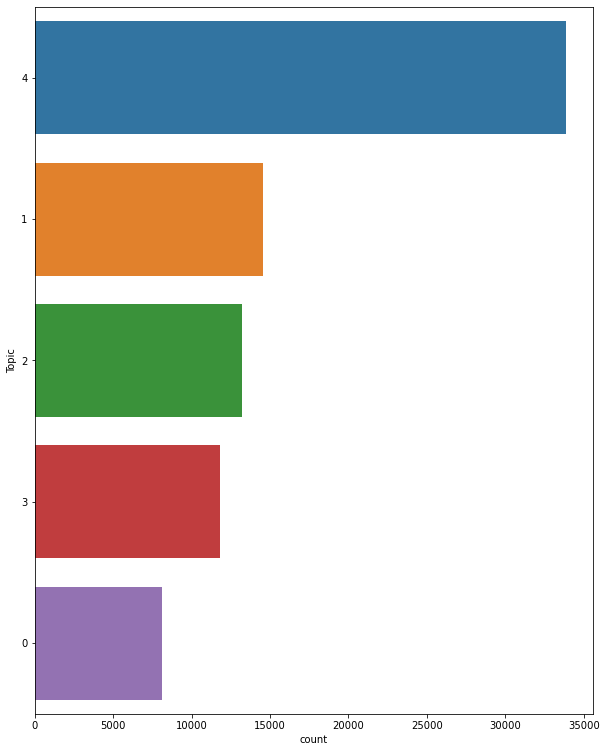

In [75]:
print(data_nlp2["Topic"].value_counts())
plt.figure(figsize=(10,13))
descending_order = data_nlp2['Topic'].value_counts().sort_values(ascending=False).index
sns.countplot(data = data_nlp2, y = "Topic",order = descending_order)

Aca podemos tener una dimension del cluster y como agrupo el contenido

<font size = 5>Basicamente lo que hicimos es clusterizar a partir de la columna title con una tecnica de LDA de topic modelling, permitio agrupar por palabras tomando el campo title, la descripciones parecidas tienen un topic, esto podria ayudar a recomendar distintos tipos de departamentos dependiendo lo que las personas buscan al buscar propiedades en properatti</font>